# Pose Approximation Refinement

Expected Data format:

- `*.npz`
- `x` - images (N, 224, 224, 3)
- `y` - ground truth vertices for hand landmarks (N, 21, 2)
- `raw_pred` - Represents the prediction of another model. This Notebook aims to answer the question whether GNNs can refine the results. (N, 21, 2)

In [62]:
import numpy as np
import torch
from typing import List
from torch_geometric.data import Data, InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, ds_name: str, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)

        self.load_dataset(ds_name)
        self.construct_graph_edges()

    def load_dataset(self, ds_name: str):
        # NOTE: x - rgb images, y - vertices (21, 2), raw_pred - landmarks by mediapipe model or other model (21, 2)
        data = np.load(ds_name)
        # Filter out invalid raw_pred entries (containing negative values)
        invalid_raw_pred = np.array([np.any(it < 0) for it in data["raw_pred"]])

        raw_pred = data["raw_pred"][~invalid_raw_pred]
        self.raw_pred = torch.tensor(raw_pred, dtype=torch.float)

        filtered_x = data["x"][~invalid_raw_pred]
        shape = filtered_x.shape
        assert shape[1] == shape[2], "Expect square images"
        img_side_len = shape[1]
        assert filtered_x.dtype == np.uint8, "Expect uint8 images"
        x = filtered_x.astype('float32') / 255.0
        self.x = torch.tensor(x, dtype=torch.float)

        y = data["y"][~invalid_raw_pred] / img_side_len # Normalize to [0, 1] similarly to mediapipe
        self.y = torch.tensor(y, dtype=torch.float)
        

    def construct_graph_edges(self):
        # NOTE: MediaPipe Hand landmark model: https://mediapipe.readthedocs.io/en/latest/solutions/hands.html
        anatomical_connections = [
            (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
            (5,6), (5,9), (6,7), (7,8), (9,10), (9,13),
            (10,11), (11,12), (13,14), (13,17), (14,15),
            (15,16), (17,18), (18,19), (19,20)
        ]
        # Create the edge list and make it undirected by adding reverse connections (same for all graphs)
        temp = []
        for a, b in anatomical_connections:
            temp.append([a, b])
            temp.append([b, a])  # Add the reverse connection
        anatomical_connections = temp

        inverse_graph_connections = []
        for i in range(21):
            for j in range(21):
                conn = (i, j)
                if conn not in anatomical_connections and i != j:
                    inverse_graph_connections.append(conn)

        # Assumed to have edges both ways between nodes when undirected
        connection_choice = anatomical_connections # inverse_graph_connections

        self.edge_index = edge_index = torch.tensor(connection_choice, dtype=torch.long).t().contiguous()

    def len(self):
        return self.y.shape[0]

    def get(self, idx):
        return Data(
            x=self.raw_pred[idx], # In the context of the graph x is the feature vector (previously detected hand landmarks)
            y=self.y[idx],
            image=self.x[idx],
            edge_index=self.edge_index
        )

In [63]:
dataset = GraphDataset(ds_name="evaluation_dataset.npz")

print(f'Dataset: {dataset}:')
print('====================')

data = dataset[0]  # Get the first graph object.
display(data)

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: GraphDataset(3593):


Data(x=[21, 2], edge_index=[2, 42], y=[21, 2], image=[224, 224, 3])

Number of nodes: 21
Number of edges: 42
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


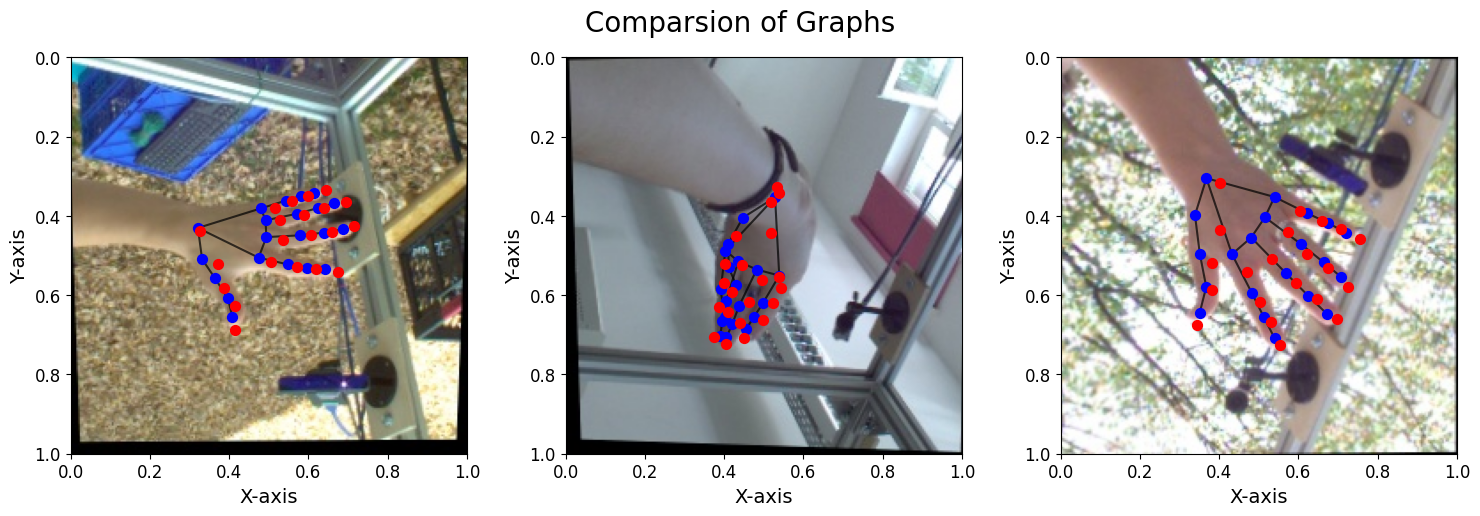

In [76]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graphs_side_by_side(dataset, indices):
    num_graphs = len(indices)
    fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 5))
    if num_graphs == 1:
        axs = [axs]  # Ensure axs is iterable even if there's only one plot

    fig.suptitle("Comparsion of Graphs", fontsize=20)

    for ax, idx in zip(axs, indices):
        data = dataset[idx]

        # Background image (fit to 0-1 coordinate space)
        img = data.image.numpy()  # shape (H, W, 3), normalized 0-1
        ax.imshow(img, extent=[0, 1, 0, 1], origin='upper', aspect='auto')

        # Node features
        x1, y1 = data.x[:, 0].numpy(), data.x[:, 1].numpy()
        y1 = 1.0 - y1
        x2, y2 = data.y[:, 0].numpy(), data.y[:, 1].numpy()
        y2 = 1.0 - y2

        # Graph edges
        edge_index = data.edge_index.numpy()
        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        # Draw first set of nodes (blue)
        pos_x = {i: (x1[i], y1[i]) for i in range(len(x1))}
        nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='blue', ax=ax)
        nx.draw_networkx_edges(G, pos_x, width=1.5, alpha=0.7, ax=ax)

        # Draw second set of nodes (red)
        pos_y = {i: (x2[i], y2[i]) for i in range(len(x2))}
        nx.draw_networkx_nodes(G, pos_y, node_size=50, node_color='red', ax=ax)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.invert_yaxis()  # optional, depends on how you want y-axis
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)
        ax.set_xlabel("X-axis", fontsize=14)
        ax.set_ylabel("Y-axis", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage
random_indices = random.sample(range(len(dataset)), 3)
random_indices = [0,1,2]
visualize_graphs_side_by_side(dataset, indices=random_indices)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torchvision import models

# TODO create this shit in pure pytroch

class HandGCN(nn.Module):
    def __init__(
        self,
        output_size=(21, 2), # (num_keypoints, 2)
        gcn_latent_dim=64,
    ):
        super().__init__()
        self.output_size = output_size

        # Resnet backbone with removed classification layer
        resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, self.output_size[0] * self.output_size[1])  # ResNet18 outputs 512-d features

        self.gcn1 = GCNConv(self.output_size[1], gcn_latent_dim)
        self.gcn2 = GCNConv(gcn_latent_dim, self.output_size[1])

        self.edge_index = ... # TODO fixed

    def forward(self, images):
        x = self.resnet(x)  # (B, 512, 1, 1)
        x = self.flatten(x) # (B, 512)
        x = self.fc(x)      # (B, 42)
        x = x.view(-1, self.output_size[0], self.output_size[1])  # (B, 21, 2)

        x = self.gcn1(x, edge_index)
        x = self.gcn2(x, edge_index)
        
        return x
